This notebook shows how we transform ANN 1 from keras into pytorch for the offline evaluation. 


In [1]:
import tensorflow as tf
from cbrain import *
import torch as to
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda,Dropout
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

2023-06-29 12:05:06.619163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#define some general hyperparameter


original_dim_input=109  # CBRAIN input node size

original_dim_output=int(112) # CBRAIN output node size 


input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 405

batch_size = 3551





In [3]:
# load keras model

ANN_1=ke.models.load_model('real_geography/ANNs/ANNs_lin/ANN_1/ANN_1_CRM_lin_model.h5')
ANN_1.summary()
ANN_1_weights=ANN_1.get_weights()

batch_size= 3551


Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 dense (Dense)               (None, 405)               44550     
                                                                 
 dense_1 (Dense)             (None, 405)               164430    
                                                                 
 dense_2 (Dense)             (None, 405)               164430    
                                                                 
 dense_3 (Dense)             (None, 405)               164430    
                                                                 
 dense_4 (Dense)             (None, 112)               45472     
                                                                 
 dense_5 (Dense)             (None, 112)               12656   

2023-06-29 12:05:36.190027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# load pytorch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# rebuild the model in pytorch

class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()
        self.X_1=nn.Linear(109,405)
        self.X_2=nn.Linear(405,405)
        self.X_3=nn.Linear(405,405)
        self.X_4=nn.Linear(405,405)
        self.X_5=nn.Linear(405,112)
        self.X_6=nn.Linear(112,112)

    def forward(self,x):
        x=F.elu_(self.X_1(x))
        x=F.elu_(self.X_2(x))
        x=F.elu_(self.X_3(x))
        x=F.elu_(self.X_4(x))
        x=F.elu_(self.X_5(x))
        x=self.X_6(x)

        
        return x
    
    
        



        


In [6]:
# build model
ANN_1_torch=ANN()
print(ANN_1_torch)

ANN(
  (X_1): Linear(in_features=109, out_features=405, bias=True)
  (X_2): Linear(in_features=405, out_features=405, bias=True)
  (X_3): Linear(in_features=405, out_features=405, bias=True)
  (X_4): Linear(in_features=405, out_features=405, bias=True)
  (X_5): Linear(in_features=405, out_features=112, bias=True)
  (X_6): Linear(in_features=112, out_features=112, bias=True)
)


the next block loads the keras weights into the pytorch model 

In [7]:
ANN_1_torch.X_1.weight.data=to.from_numpy(np.transpose(ANN_1_weights[0]))
ANN_1_torch.X_1.bias.data=to.from_numpy(np.transpose(ANN_1_weights[1]))
ANN_1_torch.X_2.weight.data=to.from_numpy(np.transpose(ANN_1_weights[2]))
ANN_1_torch.X_2.bias.data=to.from_numpy(np.transpose(ANN_1_weights[3]))
ANN_1_torch.X_3.weight.data=to.from_numpy(np.transpose(ANN_1_weights[4]))
ANN_1_torch.X_3.bias.data=to.from_numpy(np.transpose(ANN_1_weights[5]))
ANN_1_torch.X_4.weight.data=to.from_numpy(np.transpose(ANN_1_weights[6]))
ANN_1_torch.X_4.bias.data=to.from_numpy(np.transpose(ANN_1_weights[7]))
ANN_1_torch.X_5.weight.data=to.from_numpy(np.transpose(ANN_1_weights[8]))
ANN_1_torch.X_5.bias.data=to.from_numpy(np.transpose(ANN_1_weights[9]))
ANN_1_torch.X_6.weight.data=to.from_numpy(np.transpose(ANN_1_weights[10]))
ANN_1_torch.X_6.bias.data=to.from_numpy(np.transpose(ANN_1_weights[11]))


build the output normalization

In [8]:
in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 2 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values




# defining the scaling dict for the ANN training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std   
}







from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];




val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [2]:
from cbrain.save_weights import save_norm

2023-12-01 16:07:40.536678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Save the output and input normalization for the online couling 

In [8]:
#save_norm(val_gen_II.input_transform,val_gen_II.output_transform,'real_geography/ANNs/ANNs_lin_t_dt/')

In [10]:
#predict one time atep with keras

pred_keras= ANN_1.predict(val_gen_II[300][0])

432/432 [==============================] - 1s 968us/step


In [11]:
print(pred_keras.shape)
pred_keras

(13824, 112)


array([[-5.27734301e-10,  6.50197762e-09,  2.73348633e-09, ...,
         4.95974422e-01,  1.83276582e+00,  9.92179275e-01],
       [-5.33759703e-10,  6.57473720e-09,  2.76577339e-09, ...,
         4.96491402e-01,  1.83230650e+00,  9.92047250e-01],
       [-5.33759703e-10,  6.57473720e-09,  2.76440915e-09, ...,
         4.96480078e-01,  1.83231580e+00,  9.92050588e-01],
       ...,
       [-1.13038823e-09,  1.40089469e-08,  5.88670446e-09, ...,
         2.57734209e-02, -1.03362724e-02,  7.96433538e-03],
       [-1.12936505e-09,  1.39998519e-08,  5.88306648e-09, ...,
         2.57738307e-02, -1.03358105e-02,  7.96517730e-03],
       [-1.14130216e-09,  1.41490091e-08,  5.94627636e-09, ...,
         2.57560238e-02, -1.03407949e-02,  7.94787705e-03]], dtype=float32)

In [12]:
#predict one time step with pytorch
pred_pytorch=ANN_1_torch(to.from_numpy(val_gen_II[300][0]))

In [13]:
pred_pytorch[0]

tensor([-5.2773e-10,  6.5020e-09,  2.7335e-09, -1.7458e-09, -1.2718e-06,
        -9.2373e-07, -8.6501e-07, -2.5504e-07, -1.1142e-06,  8.1063e-06,
         2.2276e-05,  2.8837e-05,  3.0206e-05, -1.5208e-05, -6.7761e-05,
         1.5783e-04,  7.2139e-04,  7.4831e-04, -4.6379e-04, -2.0196e-03,
         2.7472e-03,  1.1260e-02, -2.8386e-03, -7.3985e-03, -7.1659e-03,
        -5.9188e-03,  4.4596e-02,  2.3259e-03, -3.8050e-03,  4.2549e-03,
         8.1349e-03,  8.2600e-03,  8.1587e-03,  3.1778e-03,  7.4579e-03,
         5.0174e-03,  3.8149e-03,  1.1864e-03, -2.4277e-04, -9.7223e-04,
        -3.6512e-03, -6.2631e-03, -9.9795e-03, -1.6903e-02, -1.9619e-02,
        -1.7854e-02, -2.3263e-02, -2.3722e-02, -2.1735e-02, -2.1371e-02,
        -3.8084e-02,  2.8546e-02,  1.9934e-09, -2.5616e-09, -3.0095e-09,
        -5.9663e-09,  1.5034e-09,  2.4470e-09, -2.8494e-09,  3.3078e-09,
         1.3081e-09, -2.5980e-09, -1.1426e-09,  6.0363e-09,  2.6371e-09,
         6.5993e-09,  1.0780e-06,  9.0860e-06,  9.4

In [14]:
# repeat the forward pass (prediction) and save the weights and biases 
module = to.jit.trace(ANN_1_torch.forward, to.from_numpy(val_gen_II[300][0]))

In [15]:
# the same but here the entire model structure is saved 
mod = to.jit.trace(ANN_1_torch, to.from_numpy(val_gen_II[300][0]))

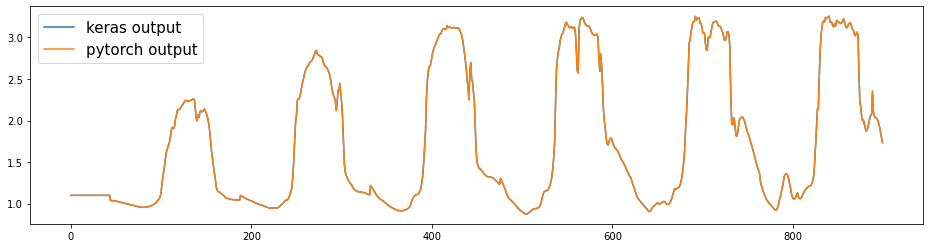

In [16]:
#compare the different predictions with each other 
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,106],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,106],label='pytorch output')
plt.legend(fontsize=15)

In [17]:
a=np.isclose(pred_keras,pred_pytorch.detach().numpy(),atol=2E-6)

In [18]:
a.shape

(13824, 112)

In [19]:
np.where(a==False)[0].size

54

In [20]:
np.where(a==True)[0].size

1548234

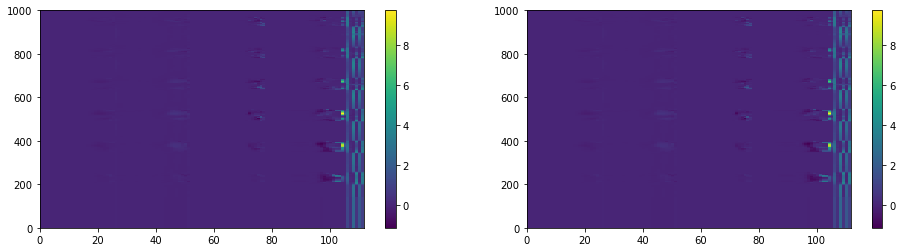

In [21]:
plt.figure(1,(16,4))
plt.subplot(1,2,1)
plt.pcolor(pred_keras[0:1000])
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolor(pred_pytorch.detach().numpy()[0:1000])
plt.colorbar()

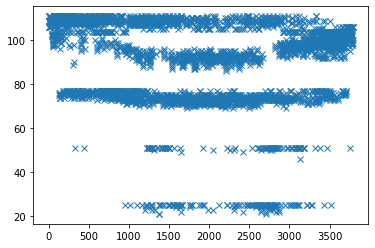

In [22]:
plt.plot(np.where(pred_keras-pred_pytorch.detach().numpy()>=1E-6)[1],'x')#np.max(pred_keras-pred_pytorch.detach().numpy()))

In [23]:
#save the weights and biases of pytorch ANN1 
to.save(ANN_1_torch,'real_geography/ANNs/ANN_1/ANN_1_CRM_lin.pt')

In [24]:
#save the entire ANN 1 in pytorch 
to.jit.save(mod,'real_geography/ANNs/ANN_1/ANN_1_CRM_lin_jit.pt')